In [1]:
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import arviz as az
import pandas as pd
import plotly.express as px

In [2]:
sns.set()

In [3]:
drowings = np.loadtxt("../data/drowning.txt")
drowings;

## Factory data

The factory data contains quality control measurements from 6
machines in a factory (units of the measurements are irrelevant here). In the data file, each column
contains the measurements for a single machine. Quality control measurements are expensive and
time-consuming, so only 5 measurements were done for each machine

In [4]:
df_wide = pd.read_csv("../data/factory.csv")
df_wide.set_index("measurement", inplace=True)
df_wide.columns.name = "machine"
df_wide

machine,M1,M2,M3,M4,M5,M6
measurement,,,,,,
0,83.0,117.0,101.0,105.0,79.0,57.0
1,92.0,109.0,93.0,119.0,97.0,92.0
2,92.0,114.0,92.0,116.0,103.0,104.0
3,46.0,104.0,86.0,102.0,79.0,77.0
4,67.0,87.0,67.0,116.0,92.0,100.0


A "wide" format is more convenient for the following analyises. Let us melt the dataframe!

In [5]:
df = pd.melt(df_wide.reset_index(),
             id_vars=["measurement"],
             value_vars=['M1', 'M2', 'M3', 'M4', 'M5', 'M6'],
             value_name='quality')
df["machine"] = df["machine"].astype("category")
df.head()

,measurement,machine,quality
0,0,M1,83.0
1,1,M1,92.0
2,2,M1,92.0
3,3,M1,46.0
4,4,M1,67.0


## Some traditional analysis

* Obtain the pooled (global) mean and standard deviation of quality measurement

In [6]:
df["quality"].mean(), df["quality"].std()

(92.93333333333334, 18.001787906096773)

* Plot the histogram of the quality measurement

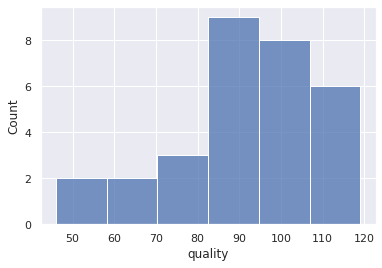

In [7]:
sns.histplot(df["quality"]);
#px.histogram(df["quality"]);

* Obtain the mean and standard deviation of quality measurement, for the different machines

In [8]:
df.groupby("machine")[["quality"]].agg(["mean", "std"])

quality           
           mean        std
machine                   
M1         76.0  19.634154
M2        106.2  11.819475
M3         87.8  12.794530
M4        111.6   7.569676
M5         90.0  10.770330
M6         86.0  19.222383

* Draw boxplots of quality for the different facto

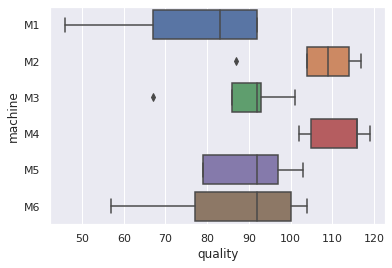

In [9]:
sns.boxplot(data=df, x="quality", y="machine");
#px.box(df, x="quality", y="machine")

Even from a classical analysis, there seems to be evidence that different machines have different quality

## Pooled Bayesian model

\begin{align*}
y_{ij} &\sim \mathcal{N}(\mu, \sigma) \\
\mu &\sim \mathcal{N}(92, 100) \\
\sigma &\sim |\mathcal{N}|(0, 100) \\
\end{align*}


* Implement the pooled model in pymc3

In [10]:
pd.DataFrame(stats.halfnorm.rvs(size=1000, scale=15)).describe()

,0
count,1000.000000
mean,11.371889
std,8.950055
min,0.032019
25%,4.271159
50%,9.434757
75%,16.745689
max,46.483348


In [11]:
with pm.Model() as model_pooled:
    mu = pm.Normal('mu', mu=92.5, sd=10)
    std = pm.HalfNormal('std', sd=15)
    y = pm.Normal('y', mu=mu, sd=std, observed=df["quality"])
    trace_pooled = pm.sample(10_000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [std, mu]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 7 seconds.


In [12]:
with model_pooled:
    display(az.summary(trace_pooled))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,92.881,3.219,86.891,99.027,0.018,0.013,32915.0,25621.0,1.0
std,18.257,2.409,13.897,22.679,0.014,0.010,31164.0,25862.0,1.0


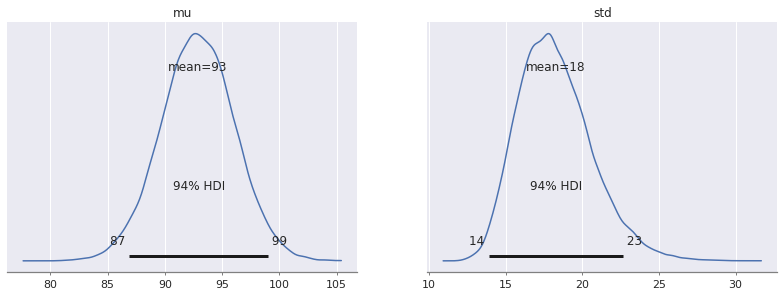

In [13]:
with model_pooled:
    az.plot_posterior(trace_pooled);

In [14]:
#std_pooled_trace = np.array(trace_pooled.posterior["std"]).reshape(-1)
#plt.hist(std_pooled_trace, bins=50);

## Unpooled Bayesian Model

\begin{align*}
y_{ij} &\sim \mathcal{N}(\mu_j, \sigma_j) \\
\mu_{j} &\sim \mathcal{N}(0, 1) \\
\sigma_{j} &\sim |\mathcal{N}|(0, \sigma_j) \\
\end{align*}



* Implement the unpooled model in pymc3

In [15]:
df["machine"] = df["machine"].astype("category")
df["machine_id"] = df["machine"].cat.codes
#df["machine"].cat.categories
#df["machine"].cat.codes
machines = list(df["machine"].cat.categories)
n_machines = len(machines) # number of machines (6)
df.head()

,measurement,machine,quality,machine_id
0,0,M1,83.0,0
1,1,M1,92.0,0
2,2,M1,92.0,0
3,3,M1,46.0,0
4,4,M1,67.0,0


In [16]:
with pm.Model() as model_unpooled:
    group_mu = pm.Normal('group_mu', mu=92.5, sd=100, shape=n_machines)
    group_std = pm.HalfNormal('group_std', sd=100, shape=n_machines)
    y = pm.Normal('y', mu=group_mu[df["machine_id"]], sd=group_std[df["machine_id"]], observed=df["quality"])
    trace_unpooled = pm.sample(10_000, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_mu]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 13 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [17]:
with model_unpooled:
    display(az.summary(trace_unpooled))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
group_mu[0],76.250,14.180,50.833,104.021,0.117,0.083,20446.0,15868.0,1.0
group_mu[1],106.147,9.183,89.426,123.748,0.076,0.057,23033.0,14845.0,1.0
group_mu[2],87.922,9.886,69.813,106.019,0.080,0.058,23446.0,16235.0,1.0
group_mu[3],111.585,6.183,100.513,122.922,0.063,0.046,15389.0,11991.0,1.0
group_mu[4],90.060,8.550,74.622,106.031,0.074,0.054,19960.0,14580.0,1.0
group_mu[5],86.251,14.024,60.236,113.018,0.109,0.077,23432.0,17428.0,1.0
group_std[0],28.908,15.347,9.955,55.336,0.122,0.090,23425.0,17320.0,1.0
group_std[1],17.959,10.517,5.972,35.092,0.087,0.065,23830.0,16729.0,1.0
group_std[2],19.400,11.319,6.940,38.406,0.095,0.070,24363.0,17274.0,1.0
group_std[3],11.823,7.575,4.008,23.484,0.072,0.051,20989.0,13716.0,1.0


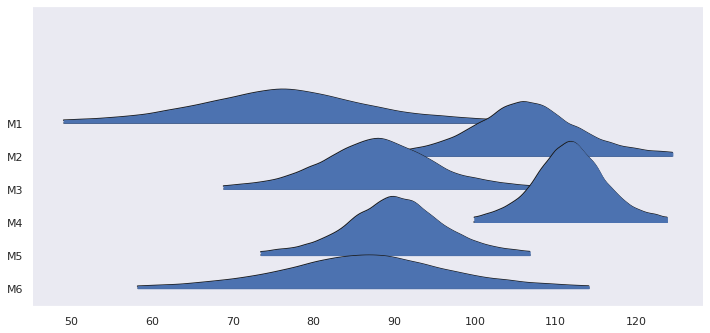

In [18]:
with model_unpooled:
    axes = az.plot_forest (trace_unpooled,  kind='ridgeplot', hdi_prob=0.95, var_names="group_mu", combined=True);
    axes[0].set_yticklabels(machines[::-1])

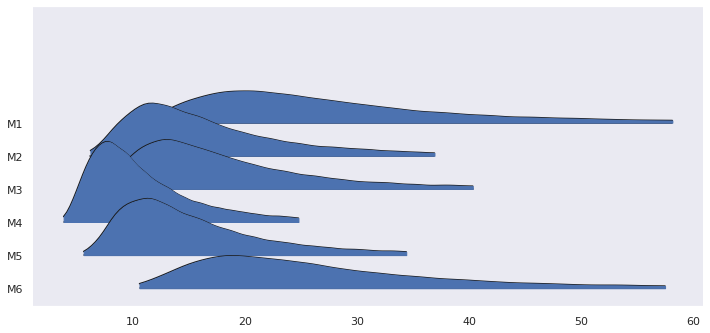

In [19]:
with model_unpooled:
    axes = az.plot_forest (trace_unpooled,  kind='ridgeplot', hdi_prob=0.95, var_names="group_std", combined=True);
    axes[0].set_yticklabels(machines[::-1])

* Compare the sample unpooled standard deviation with the bayesian estimate. What do you observe?

We already computed the sample standard deviations before:

In [20]:
df.groupby("machine")[["quality"]].agg(["mean", "std"])

quality           
           mean        std
machine                   
M1         76.0  19.634154
M2        106.2  11.819475
M3         87.8  12.794530
M4        111.6   7.569676
M5         90.0  10.770330
M6         86.0  19.222383

The posterior means of the bayesian estimates are:

In [21]:
with model_unpooled:
    display(az.summary(trace_unpooled, var_names=["group_std"]))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
group_std[0],28.908,15.347,9.955,55.336,0.122,0.090,23425.0,17320.0,1.0
group_std[1],17.959,10.517,5.972,35.092,0.087,0.065,23830.0,16729.0,1.0
group_std[2],19.400,11.319,6.940,38.406,0.095,0.070,24363.0,17274.0,1.0
group_std[3],11.823,7.575,4.008,23.484,0.072,0.051,20989.0,13716.0,1.0
group_std[4],16.633,10.128,5.571,32.785,0.089,0.066,21680.0,16193.0,1.0
group_std[5],28.435,15.170,10.075,54.714,0.114,0.082,24239.0,20743.0,1.0


In [22]:
#plt.hist(trace_separate["group_std"][:, 5], bins=50);
#trace_std = np.array(trace_separate.posterior["group_std"]).reshape(-1, machines)
#px.histogram(trace_std[:, 0])#, bins=50);

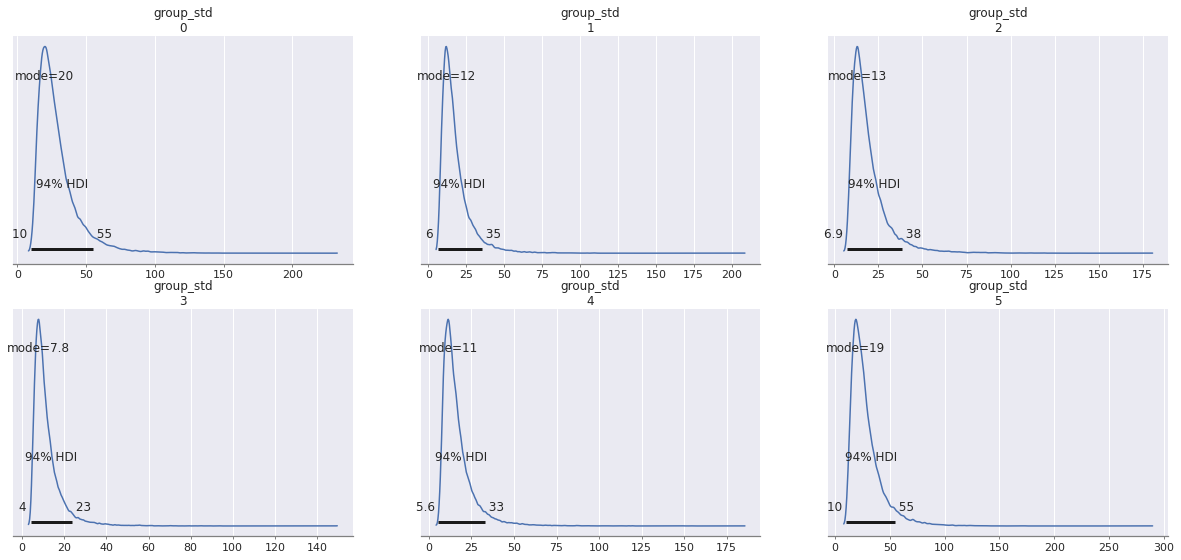

In [23]:
# az.plot_posterior(trace_separate["group_std"][:, 0], point_estimate='mode')
with model_unpooled:
    az.plot_posterior(trace_unpooled, var_names=["group_std"], point_estimate='mode'); # the posterior mean is 29, the mode is 19!

The sample std is rather different from the posterior std mean. The sample std is actually much similar to the posterior mode (as expected from theory)! The posterior std distributions are heaviy right-skewed!

## Hierarchical model, common std

\begin{align*}
y_{ij} &\sim \mathcal{N}(\mu_j, \sigma_j) \\
\mu_{j} &\sim \mathcal{N}(0, 1) \\
\sigma_{j} &\sim |\mathcal{N}|(0, \sigma_j) \\
\end{align*}



* Implement the hierarchical model with common std in pymc3

In [24]:
with pm.Model() as model_hierarchical:
    
    # hyper_priors
    hyper_mu_mu = pm.Normal('hyper_mu_mu', mu=92, sd=100)
    hyper_mu_std = pm.HalfNormal('hyper_mu_std', sd=100)

    # priors    
    group_mu = pm.Normal('group_mu', mu=hyper_mu_mu, sd=hyper_mu_std, shape=n_machines)
    std = pm.HalfNormal('std', sd=100)
    y = pm.Normal('y', mu=group_mu[df["machine_id"]], sd=std, observed=df["quality"])
    trace_hierarchical = pm.sample(10_000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [std, group_mu, hyper_mu_std, hyper_mu_mu]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 14 seconds.
There were 190 divergences after tuning. Increase `target_accept` or reparameterize.
There were 334 divergences after tuning. Increase `target_accept` or reparameterize.
There were 225 divergences after tuning. Increase `target_accept` or reparameterize.
There were 134 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [25]:
az.summary(trace_hierarchical)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
hyper_mu_mu,92.988,7.863,78.255,107.849,0.054,0.038,25031.0,20820.0,1.0
group_mu[0],79.997,6.806,67.900,93.581,0.077,0.057,8064.0,2881.0,1.0
group_mu[1],103.124,6.496,90.925,115.152,0.052,0.036,15571.0,13361.0,1.0
group_mu[2],89.033,6.178,77.342,100.586,0.039,0.028,25118.0,23207.0,1.0
group_mu[3],107.298,6.952,93.887,120.256,0.072,0.051,9682.0,4767.0,1.0
group_mu[4],90.688,6.157,78.482,101.588,0.035,0.025,31536.0,26299.0,1.0
group_mu[5],87.578,6.178,75.833,99.081,0.040,0.029,23654.0,21313.0,1.0
hyper_mu_std,15.914,8.949,3.465,31.499,0.093,0.066,3911.0,1608.0,1.0
std,15.213,2.367,11.003,19.583,0.020,0.015,15840.0,12577.0,1.0


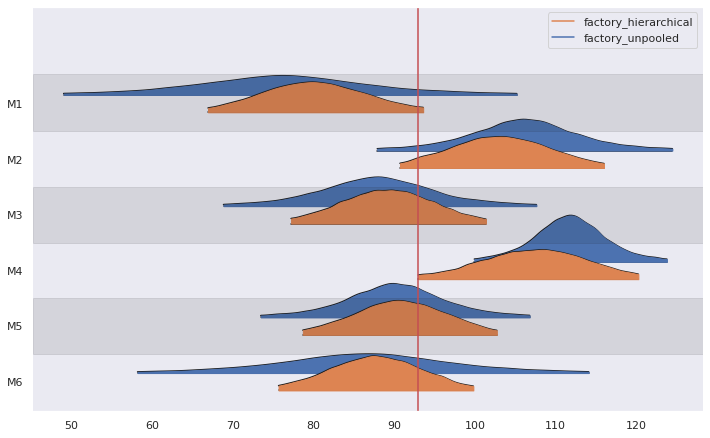

In [26]:
axes = az.plot_forest([trace_unpooled, trace_hierarchical], 
                      model_names=['factory_unpooled', 'factory_hierarchical'], combined=True, kind='ridgeplot', var_names='group_mu', hdi_prob=0.95);

grand_mean = df["quality"].mean()
axes[0].axvline(x=grand_mean, color="r", label="grand_mean");
axes[0].set_yticklabels(machines[::-1]);

In the hierarchical model, the machine means are pushed towards the grand mean

## Model selection 

In [27]:
#with factory_pooled, factory_separate, factory_hierarchical:
comp_df = az.compare({"model_pooled": trace_pooled,
                      "model_unpooled": trace_unpooled,
                      "model_hierarchical": trace_hierarchical},
                     ic="waic", method="BB-pseudo-BMA")
comp_df

/home/marco/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/marco/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/marco/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model_hierarchical,0,-126.574361,5.435885,0.000000,0.830463,4.314139,0.000000,True,log
model_unpooled,1,-130.287312,8.161942,3.712951,0.111231,2.734721,2.446110,True,log
model_pooled,2,-130.809680,1.975046,4.235319,0.058306,3.996588,2.099998,True,log


In [28]:
comp_df

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model_hierarchical,0,-126.574361,5.435885,0.000000,0.830463,4.314139,0.000000,True,log
model_unpooled,1,-130.287312,8.161942,3.712951,0.111231,2.734721,2.446110,True,log
model_pooled,2,-130.809680,1.975046,4.235319,0.058306,3.996588,2.099998,True,log


<AxesSubplot:xlabel='Log'>

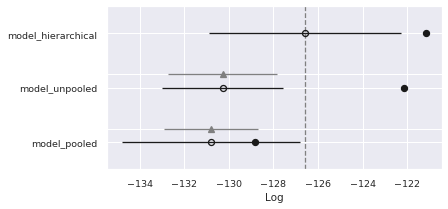

In [29]:
az.plot_compare(comp_df)

## Manual WAIC computations

Let us compare the arviz computation of WAIC with a manual implementation:

In [30]:
with model_hierarchical:
    display(az.waic(trace_hierarchical))

/home/marco/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 40000 posterior samples and 30 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -126.57     4.03
p_waic        5.44        -

There has been a warning during the calculation. Please check the results.

In [31]:
log_lik = np.array(trace_hierarchical.log_likelihood.y) # chains, iters, obs
log_lik = log_lik.reshape((-1, log_lik.shape[-1])) # mc samples, obs
S, ny = log_lik.shape

In [32]:
p_waic = np.var(log_lik, axis=0) # correct
p_waic = np.sum(p_waic)
p_waic

5.43588492512978

In [33]:
lppd = scipy.special.logsumexp(log_lik, axis=0) - np.log(S) # sum is equivalent to logsumexp in log domain...
lppd = np.sum(lppd)
lppd

-121.13847588337028

In [34]:
-2*(lppd - p_waic)

253.14872161700012

In [35]:
lppd - p_waic

-126.57436080850006

## With predictive distribution

TODO

In [ ]:
with pm.Model() as model_pooled_with_pred:
    mu = pm.Normal('mu', mu=92.5, sd=10)
    std = pm.HalfNormal('std', sd=15)
    y = pm.Normal('y', mu=mu, sd=std, observed=df["quality"])
    
    # Prediction
    y_pred = pm.Normal('y_pred', mu=mu, sd=std)
    trace_pooled_with_pred = pm.sample(10_000, return_inferencedata=True)

In [ ]:
#trace_pooled_with_pred.posterior.y_pred

In [ ]:
with pm.Model() as model_hierarchical_with_pred:
    
    # hyper_priors
    hyper_mu_mu = pm.Normal('hyper_mu_mu', mu=92, sd=100)
    hyper_mu_std = pm.HalfNormal('hyper_mu_std', sd=100)

    # priors    
    group_mu = pm.Normal('group_mu', mu=hyper_mu_mu, sd=hyper_mu_std, shape=n_machines)
    std = pm.HalfNormal('std', sd=100)
    y = pm.Normal('y', mu=group_mu[df["machine_id"]], sd=std, observed=df["quality"])
    
    
    pred_mu = pm.Normal('pred_mu', mu=hyper_mu_mu, sd=hyper_mu_std)
    pred_y = pm.Normal('pred_y', mu=pred_mu, sd=std)
    
    
    trace_hierarchical_with_pred = pm.sample(10_000, return_inferencedata=True)
    
    
    

In [47]:
with pm.Model() as model_hierarchical_with_pred:
    
    # hyper_priors
    hyper_mu_mu = pm.Normal('hyper_mu_mu', mu=92, sd=100)
    hyper_mu_std = pm.HalfNormal('hyper_mu_std', sd=100)

    # priors    
    group_mu = pm.Normal('group_mu', mu=hyper_mu_mu, sd=hyper_mu_std, shape=n_machines)
    std = pm.HalfNormal('std', sd=100)
    y = pm.Normal('y', mu=group_mu[df["machine_id"]], sd=std, observed=df["quality"])
    
    
    pred_mu = pm.Normal('pred_mu', mu=hyper_mu_mu, sd=hyper_mu_std)
    pred_y = pm.Normal('pred_y', mu=pred_mu, sd=std)
    
    
    trace_hierarchical_with_pred = pm.sample(10_000, return_inferencedata=True)
    
    
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pred_y, pred_mu, std, group_mu, hyper_mu_std, hyper_mu_mu]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 18 seconds.
There were 67 divergences after tuning. Increase `target_accept` or reparameterize.
There were 168 divergences after tuning. Increase `target_accept` or reparameterize.
There were 107 divergences after tuning. Increase `target_accept` or reparameterize.
There were 115 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
